# Red Ventures Data & Analytics Interview: Technical Assessment
### December 15, 2022


Firstname: Christine

Lastname: Gao

E-mail: gao.min2468@gmail.com


---

# Initial Imports and Necessary Libraries

In [434]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve

from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

import warnings
warnings.filterwarnings("ignore")

##we will only be ignoring warnings from the feature selection section

In [435]:
from time import time
def make_submission(name, data_frame):
    """
    -----------
        name:               string, your name
        data_frame:         pandas DataFrame [5999, 2], customer ids and 
                                predicted probabilities on the test set
    """
    cnames = data_frame.columns.values
    if not isinstance(data_frame, pd.DataFrame):
        raise ValueError('Expecting a pandas DataFrame for argument 2')
    elif cnames[0] != 'customer_id':
        raise ValueError('Column name 0 incorrect, expecting customer_id, received ' + cnames[0])
        
    t0 = time()
    filename = name + '.csv'
    data_frame.to_csv(filename, index = False)
    return '{fname} written in {t:.{rd}f} ms'.format(fname = filename, t = (time() - t0) / 1000., rd = 3)


# Import Data and overview

In [436]:
example_pred = pd.read_csv('example_predictions.csv')
example_pred.head()

,customer_id,pr_y
0,24002,0.5
1,24003,0.5
2,24004,0.5
3,24005,0.5
4,24006,0.5


In [437]:
test = pd.read_csv('test.csv')
df = pd.read_csv('train.csv') ##we'll treat the train csv as df for now for ease of reference thorughout the notebook
df.head()

,customer_id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_oct
0,1,1500,2.0,1.0,2.0,23.0,0.0,0.0,0.0,2.0,...,1463,938.0,698.0,75,150,86,0,50.0,50.0,yes
1,2,8500,2.0,2.0,2.0,29.0,0.0,0.0,0.0,0.0,...,8364,8275.0,8425.0,300,400,315,300,325.0,305.0,no
2,3,1000,1.0,1.0,2.0,22.0,0.0,0.0,0.0,0.0,...,933,772.0,794.0,150,150,150,24,105.0,110.0,no
3,4,10500,1.0,1.0,1.0,31.0,0.0,0.0,0.0,0.0,...,7190,7229.0,7340.0,255,260,258,260,265.0,307.0,no
4,5,10500,2.0,2.0,1.0,44.0,0.0,0.0,0.0,0.0,...,3558,3592.0,3496.0,180,155,145,130,135.0,200.0,no


In [438]:
df.info()
##overview of variables in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24001 entries, 0 to 24000
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  24001 non-null  int64  
 1   limit_bal    24001 non-null  int64  
 2   sex          24001 non-null  float64
 3   education    24001 non-null  float64
 4   marriage     24001 non-null  float64
 5   age          24001 non-null  float64
 6   pay_1        24001 non-null  float64
 7   pay_2        24001 non-null  float64
 8   pay_3        24001 non-null  float64
 9   pay_4        24001 non-null  float64
 10  pay_5        23819 non-null  float64
 11  pay_6        22790 non-null  float64
 12  bill_amt1    24001 non-null  int64  
 13  bill_amt2    24001 non-null  int64  
 14  bill_amt3    24001 non-null  int64  
 15  bill_amt4    24001 non-null  int64  
 16  bill_amt5    23819 non-null  float64
 17  bill_amt6    22790 non-null  float64
 18  pay_amt1     24001 non-null  int64  
 19  pay_

### Comment on null values

There are null values in the last two columns of payment history - lets consider this as a potential indicator that the payment was payed off in full or the individual defaulted prior to October

Null values in last two columns of bill statement in dolalrs

Null values in last two columns of previous payment in dollars

In [439]:
#df.loc[df['pay_5'].isnull()]

In [440]:
bool(df.duplicated(subset='customer_id').any()) 

##No duplicate customer id's 

False

In [441]:
df['default_oct'].value_counts()

no     18692
yes     5309
Name: default_oct, dtype: int64

In [442]:
df['sex'].value_counts()

2.0    14498
1.0     9503
Name: sex, dtype: int64

(array([1.0043e+04, 6.2680e+03, 4.0740e+03, 2.2070e+03, 1.2430e+03,
        1.0300e+02, 4.6000e+01, 1.6000e+01, 0.0000e+00, 1.0000e+00]),
 array([  500.,  5450., 10400., 15350., 20300., 25250., 30200., 35150.,
        40100., 45050., 50000.]),
 <BarContainer object of 10 artists>)

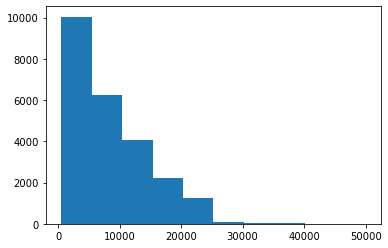

In [481]:
plt.hist(df['limit_bal'])

(array([4.110e+03, 6.598e+03, 5.173e+03, 3.879e+03, 2.096e+03, 1.465e+03,
        5.050e+02, 1.390e+02, 3.200e+01, 4.000e+00]),
 array([21. , 26.8, 32.6, 38.4, 44.2, 50. , 55.8, 61.6, 67.4, 73.2, 79. ]),
 <BarContainer object of 10 artists>)

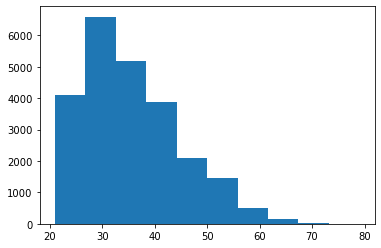

In [443]:
plt.hist(df['age'])

In [482]:
bins= [21,30,40,50,60,70,80]
labels = ['20-30','30-40','40-50','50-60','60-70','70-80']
df['age_bin'] = pd.cut(df['age'],bins=bins, labels=labels,right=False)

(array([7680.,    0., 8970.,    0., 5206.,    0., 1878.,    0.,  248.,
          19.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

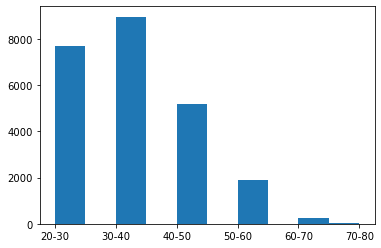

In [483]:
plt.hist(df['age_bin'])

(array([1.0043e+04, 6.2680e+03, 4.0740e+03, 2.2070e+03, 1.2430e+03,
        1.0300e+02, 4.6000e+01, 1.6000e+01, 0.0000e+00, 1.0000e+00]),
 array([  500.,  5450., 10400., 15350., 20300., 25250., 30200., 35150.,
        40100., 45050., 50000.]),
 <BarContainer object of 10 artists>)

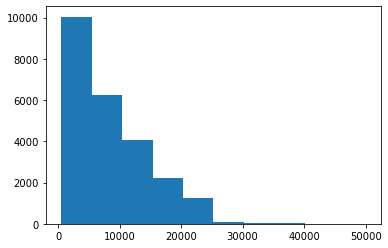

In [444]:
plt.hist(df['limit_bal'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc483bb3c10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc483bb3670>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc483bb3160>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc483bae610>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc483bae820>],
 'means': []}

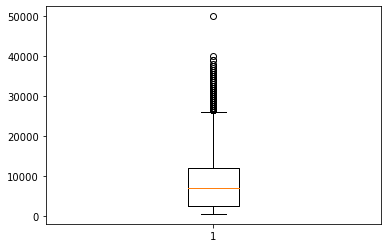

In [445]:
plt.boxplot(df['limit_bal'])

There does appear to be an outlier in terms of limit balance 

In [446]:
df.loc[df['limit_bal'] > 40000]

,customer_id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_oct
9303,9304,50000,2.0,1.0,1.0,47.0,0.0,0.0,0.0,-1.0,...,44579,46358.0,48083.0,2539,2536,44802,2500,2500.0,2512.0,no


Upon closer inspection, this customer has incredible credit history - no late payments and no default, so this is a valid data point.

# Data Cleaning

Comments on discrete values in the dataset which are not defined from the codebook

In [447]:
df['education'].value_counts()

2.0    11248
1.0     8424
3.0     3942
5.0      234
4.0      104
6.0       39
0.0       10
Name: education, dtype: int64

Since it is unclear what education values beyond 4 indicate, we'll combine 0,4,5,6 as 'others'

In [448]:
df['education'] = df['education'].replace({0:4,5:4,6:4})
df['education'].value_counts()

2.0    11248
1.0     8424
3.0     3942
4.0      387
Name: education, dtype: int64

In [449]:
df['marriage'].value_counts()

2.0    12746
1.0    10945
3.0      268
0.0       42
Name: marriage, dtype: int64

Unclear what values of 0 are in marriage, so we'll group these with 'others'

In [450]:
df['marriage'] = df['marriage'].replace({0:3})
df['marriage'].value_counts()

2.0    12746
1.0    10945
3.0      310
Name: marriage, dtype: int64

Create new column with values of 0 or 1 for our 'default_oct' - for ease of analysis later on

In [451]:
df['default_oct_imp'] = pd.Series(np.where(df['default_oct'].values == 'yes', 1, 0),
          df.index)

In [452]:
df

,customer_id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_oct,default_oct_imp
0,1,1500,2.0,1.0,2.0,23.0,0.0,0.0,0.0,2.0,...,938.0,698.0,75,150,86,0,50.0,50.0,yes,1
1,2,8500,2.0,2.0,2.0,29.0,0.0,0.0,0.0,0.0,...,8275.0,8425.0,300,400,315,300,325.0,305.0,no,0
2,3,1000,1.0,1.0,2.0,22.0,0.0,0.0,0.0,0.0,...,772.0,794.0,150,150,150,24,105.0,110.0,no,0
3,4,10500,1.0,1.0,1.0,31.0,0.0,0.0,0.0,0.0,...,7229.0,7340.0,255,260,258,260,265.0,307.0,no,0
4,5,10500,2.0,2.0,1.0,44.0,0.0,0.0,0.0,0.0,...,3592.0,3496.0,180,155,145,130,135.0,200.0,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23996,23997,1500,2.0,2.0,2.0,27.0,2.0,-1.0,0.0,0.0,...,73.0,1402.0,149,73,0,73,1402.0,55.0,yes,1
23997,23998,7000,1.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,...,2946.0,2932.0,250,110,115,115,105.0,100.0,no,0
23998,23999,8000,1.0,1.0,2.0,41.0,0.0,0.0,0.0,0.0,...,2457.0,2616.0,100,100,300,0,210.0,100.0,no,0
23999,24000,1000,2.0,3.0,1.0,50.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,187,345,14,0,0.0,0.0,yes,1


# Analysis

First, I want to investigate the bill amounts - we noticed there were several null values early on.

Are there any other interesting things of note?

<AxesSubplot:>

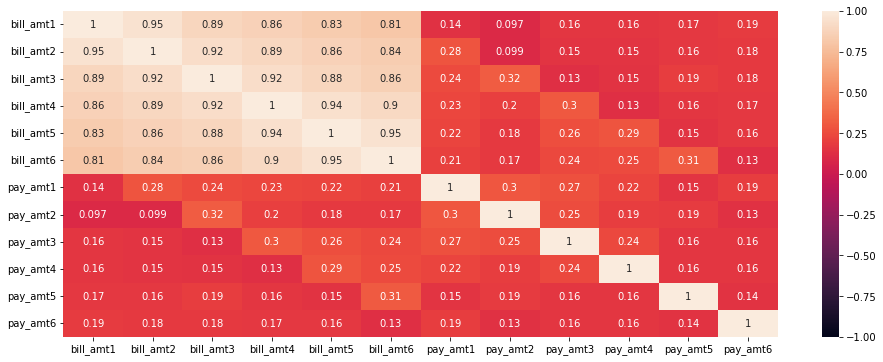

In [453]:
plt.figure(figsize=(16,6))
sns.heatmap(df.iloc[:, 12:24].corr(), vmin=-1, annot=True)

Correlation among the respective bill amounts is very high - correlations between bill amounts and payment amounts are relatively low. 

In [454]:
df.iloc[:, 12:24].describe()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,24001.000000,24001.000000,24001.000000,24001.000000,23819.000000,22790.000000,24001.000000,24001.000000,24001.000000,24001.000000,23819.000000,22790.000000
mean,2574.245865,2467.107037,2359.795592,2175.804383,2024.383559,1960.335981,281.079955,298.237073,263.109704,243.367943,238.731139,256.517069
std,3706.812804,3585.952168,3499.639871,3244.170936,3063.487512,3015.469078,846.819525,1215.481369,899.406651,782.138847,779.341974,861.106314
min,-8279.000000,-3488.000000,-3075.000000,-8500.000000,-4066.000000,-10452.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,177.000000,147.000000,130.000000,116.000000,90.000000,62.000000,49.000000,41.000000,19.000000,15.000000,12.000000,6.000000
50%,1123.000000,1059.000000,1007.000000,953.000000,906.000000,855.500000,105.000000,100.000000,90.000000,75.000000,75.000000,75.000000
75%,3375.000000,3202.000000,3015.000000,2752.000000,2510.500000,2466.000000,250.000000,250.000000,227.000000,200.000000,200.000000,200.000000
max,48225.000000,49196.000000,83204.000000,44579.000000,46358.000000,48083.000000,43677.000000,84212.000000,44802.000000,31050.000000,21326.000000,26433.000000


We also observe negative bill amounts (notice that the row 'min' displays negative values). To find those records, we will serach the df for negative bill values.

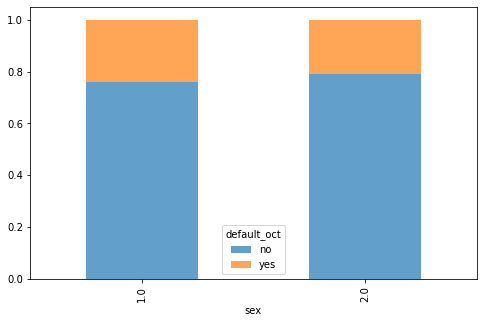

In [455]:
df_sex = df.groupby('sex')['default_oct'].value_counts(normalize=True).unstack()
df_sex.plot(kind='bar', stacked=True, figsize=(8,5), alpha=0.7)
plt.show()

No apparent differences between men and women in terms of proportion of default accounts

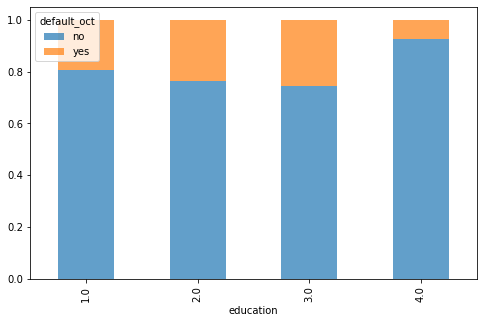

In [456]:
df_edu = df.groupby('education')['default_oct'].value_counts(normalize=True).unstack()
df_edu.plot(kind='bar', stacked=True, figsize=(8,5), alpha=0.7)
plt.show()

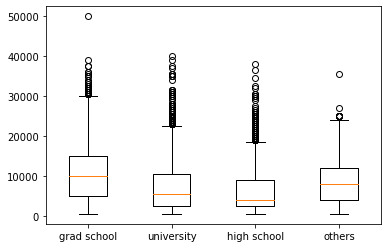

In [457]:
data = []
for i in [1,2,3,4]:
    temp = df.loc[df['education'] == i, "limit_bal"]
    data.append(temp)
    
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(["grad school","university", "high school", "others"])

plt.show()

Something interesting of note here - custoemrs with the highest level of education are at the upper end of the spectrum when it comes to paying back in full, however there are some outliers in the 'others' category, which has a surprisingly low percentage. 

Additionally, the 'others' category does not have the lowest limit median limit balance - our 'others' label could include those who have a doctorate degree or dropped out of and became very well off thanks to an amazing dream/opportunity.

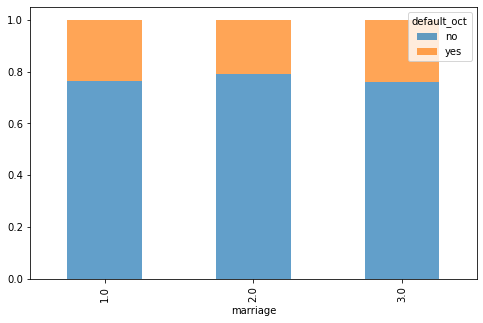

In [458]:
df_married = df.groupby('marriage')['default_oct'].value_counts(normalize=True).unstack()
df_married.plot(kind='bar', stacked=True, figsize=(8,5), alpha=0.7)
plt.show()

No apparent differences between marriage status and outcomes of defaults.

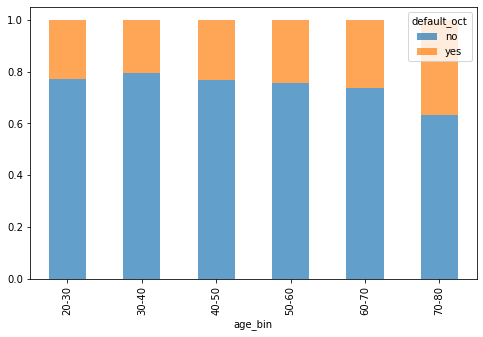

In [484]:
df_age = df.groupby('age_bin')['default_oct'].value_counts(normalize=True).unstack()
df_age.plot(kind='bar', stacked=True, figsize=(8,5), alpha=0.7)
plt.show()

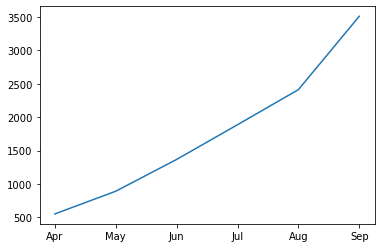

In [459]:
defaulted = df[df['default_oct_imp']==1]
default_trend = defaulted[['pay_6','pay_5','pay_4','pay_3','pay_2','pay_1']].sum(axis=0)

# # Draw a line chart to show the trend. The lower the number, the shorter delayed payment
fig,ax = plt.subplots()
ax.plot(default_trend)
plt.xticks(['pay_6','pay_5','pay_4','pay_3','pay_2','pay_1'],['Apr','May','Jun','Jul','Aug','Sep'])
plt.show()

Time series trend - over time, the amount of delayed payments from April to September dramatically.

So, what can we gather from our data? 

It appears that delayed payments would be a serious concern for the business. There aren't too many differences between our categorical variables (sex, marriage status, and education).

We see that there are strong correlations between bill statements, but not between payment amounts. This could indicate to us that over each month, individuals who have high bill statements will continue to have high bill statements over the subsequent months.

Now this leaves us with the question - how can use what we have gathered to predict the probability of a customer defaulting on their credit card?

# Model and Results

Because I am interested in the probability of an individual defaulting, my model of choice will be a XGBClassifier with a logistic outcome (indicating the occurrence of defaulting or not).

### Selecting our Features

In [461]:
X = df.drop(columns=['customer_id', 'default_oct', 'default_oct_imp']) ##dropping our created columns
y = df['default_oct_imp'] ##default the month of october, imputed as 0,1 for no,yes

Splitting our data into train and test sets for our model

In [462]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

### Building our model.

I chose a learning rate of 0.05 (standard is between 0.1 and 0.3)
My number of estimators is 300 (traditionally, you would select a range from 100 to 500) 
The default max depth in XGBoost is 6.

Given more time, I would have like to tune the hyperparameters and compare different models, but given the time constraint we will settle for middle of the road hyperparameters.

In [463]:
xg_model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5, eval_metric ='mlogloss')
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

### XGBoost Accuracy

In [464]:
y_pred = xg_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.63%


### XGBoost Model Evaluation

In [465]:
def get_pre_rec_f1(model,X_test,y_test):
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    
    print(f'Precision:{precision:.3f}\nRecall:{recall:.3f}\nF1 score:{F1:.3f}')

In [466]:
get_pre_rec_f1(xg_model, X_test, y_test)

Precision:0.684
Recall:0.356
F1 score:0.468


### Confusion Matrix

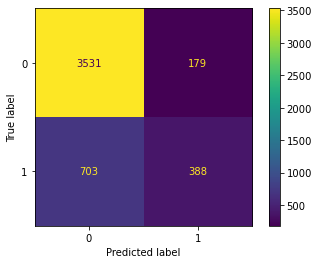

In [467]:
plot_confusion_matrix(xg_model, X_test, y_test, values_format="d")

### ROC Curve

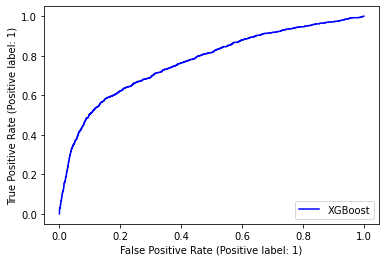

In [468]:
plot_roc_curve(xg_model, X_test, y_test, color="blue",label='XGBoost')

## Looking at the sorted feature importance

<BarContainer object of 23 artists>

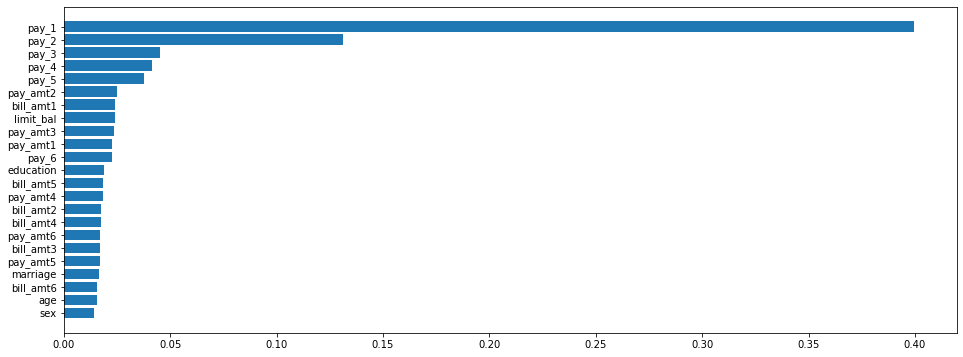

In [469]:
plt.figure(figsize=(16,6))
sorted_idx = xg_model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx] , xg_model.feature_importances_[sorted_idx])


In [470]:
thresholds = np.sort(xg_model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xg_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.014, n=23, Accuracy: 81.02%
Thresh=0.015, n=22, Accuracy: 80.65%
Thresh=0.016, n=21, Accuracy: 81.07%
Thresh=0.016, n=20, Accuracy: 80.98%
Thresh=0.017, n=19, Accuracy: 80.90%
Thresh=0.017, n=18, Accuracy: 80.80%
Thresh=0.017, n=17, Accuracy: 80.88%
Thresh=0.017, n=16, Accuracy: 80.80%
Thresh=0.017, n=15, Accuracy: 80.98%
Thresh=0.018, n=14, Accuracy: 80.67%
Thresh=0.019, n=13, Accuracy: 81.42%
Thresh=0.019, n=12, Accuracy: 80.88%
Thresh=0.023, n=11, Accuracy: 80.86%
Thresh=0.023, n=10, Accuracy: 80.98%
Thresh=0.023, n=9, Accuracy: 81.42%
Thresh=0.024, n=8, Accuracy: 81.15%
Thresh=0.024, n=7, Accuracy: 81.21%
Thresh=0.025, n=6, Accuracy: 81.50%
Thresh=0.038, n=5, Accuracy: 81.86%
Thresh=0.041, n=4, Accuracy: 81.59%
Thresh=0.045, n=3, Accuracy: 81.63%
Thresh=0.131, n=2, Accuracy: 81.63%
Thresh=0.400, n=1, Accuracy: 81.46%


Even when we decreased our selected features, the apparent accuracy of the model didn't seem to change much.

Ideally, since we want to create as least-complex of a model as possible, and since our trade off of 81.63% accuracy to 81.86% is pretty good, I will select the top 5 features from our feature importance for our final model.

In [471]:
new_set = df[['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5']]
new_y = df['default_oct_imp']

By selecting the top 5 feature (which also happens to be the history of past payment), we make the assumption that the best indicators of a customer default will be their past payment history. This might hold implications in the future for when deciding at what month a customer may run the 'risk' of defaulting.

In [472]:
X_train, X_test, y_train, y_test = train_test_split(new_set, new_y, test_size=0.2, random_state=11)

In [473]:
xgb_new = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5, eval_metric ='mlogloss')
xgb_new.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [474]:
y_pred = xgb_new.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.88%


## Test set and Predictions Export

From the test set, we select the first 5 months of history payment as our features, and implement our model.

In [475]:
test_final = test[['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5']]

In [476]:
test_pred = xgb_new.predict(test_final)

In [477]:
prob = pd.DataFrame(xgb_new.predict_proba(test_final)[:,1])
prob.columns = ['pr_y']

In [478]:
customer_id = pd.DataFrame(test['customer_id'])
predictions = pd.merge(customer_id, prob, left_index=True, right_index=True)

In [479]:
predictions

,customer_id,pr_y
0,24002,0.117230
1,24003,0.140311
2,24004,0.661444
3,24005,0.439905
4,24006,0.439905
...,...,...
5994,29996,0.320690
5995,29997,0.111847
5996,29998,0.111847
5997,29999,0.398574


In [480]:
make_submission('Christine_Gao_predictions', predictions)

'Christine_Gao_predictions.csv written in 0.000 ms'